In [1]:
import pandas as pd
import re

path = r"C:\Users\DELL\Downloads\Survey\kaggle_survey_2017_2021.csv" 
df = pd.read_csv(path, skiprows=1, low_memory=False)

def find_col(substr):
    """Return the first column name containing substr (case-insensitive), else None."""
    for c in df.columns:
        if substr.lower() in c.lower():
            return c
    return None

col_year       = find_col("Year")
col_duration   = find_col("Duration (in seconds)")
col_age        = find_col("What is your age")
col_gender     = find_col("What is your gender")
col_country    = find_col("In which country do you currently reside")
col_edu        = find_col("What is the highest level of formal education")
col_title      = find_col("Select the title most similar to your current role")
col_code_years = find_col("For how many years have you been writing code")
col_reco_lang  = find_col("What programming language would you recommend")

# Multi-select language usage columns: each language is a separate column
lang_usage_cols = [c for c in df.columns
                   if "What programming languages do you use on a regular basis?" in c]

selected_cols = [c for c in [col_year, col_duration, col_age, col_gender,
                             col_country, col_edu, col_title,
                             col_code_years, col_reco_lang] if c]

# Safety check
if not selected_cols:
    raise ValueError("Could not locate expected columns. Please verify the CSV header row.")

# ========= 3) WORKING COPY & BASIC CLEANING =========
work = df[selected_cols + lang_usage_cols].copy()

# Remove exact duplicates
work = work.drop_duplicates()

# Fix common encoding artifacts (e.g., Bachelorâ€™s -> Bachelor’s)
def fix_encoding(val):
    if isinstance(val, str):
        return (val.replace("â€™", "’")
                   .replace("â€“", "–")
                   .replace("Ã±", "ñ"))
    return val

for c in [col_edu, col_title]:
    if c in work.columns:
        work[c] = work[c].map(fix_encoding)

# Fill missing values with simple defaults
fill_map = {}
if col_country:    fill_map[col_country]    = "Unknown"
if col_gender:     fill_map[col_gender]     = "Prefer not to say"
if col_edu:        fill_map[col_edu]        = "Unknown"
if col_code_years: fill_map[col_code_years] = "Unknown"
if col_reco_lang:  fill_map[col_reco_lang]  = "Unknown"
work = work.fillna(value=fill_map)

# Light formatting/standardization
if col_country in work.columns:
    work[col_country] = work[col_country].astype(str).str.title().str.strip()

# ========= 4) ENCODE CATEGORICALS =========
def add_code_col(df_in, colname, newname):
    if colname and colname in df_in.columns:
        df_in[newname] = pd.factorize(df_in[colname])[0]

add_code_col(work, col_country,    "Country_Code")
add_code_col(work, col_gender,     "Gender_Code")
add_code_col(work, col_edu,        "Education_Code")
add_code_col(work, col_title,      "JobTitle_Code")
add_code_col(work, col_code_years, "CodingExp_Code")
add_code_col(work, col_reco_lang,  "RecoLang_Code")

# ========= 5) INSIGHTS REQUIRED BY TASK =========
print("\n=== BASIC INSIGHTS ===")

if col_reco_lang in work.columns:
    print("\nTop Recommended Languages (single-choice):")
    print(work[col_reco_lang].value_counts().head(10))

if col_country in work.columns:
    print("\nTop Countries by Respondents:")
    print(work[col_country].value_counts().head(10))

if col_edu in work.columns:
    print("\nEducation Distribution:")
    print(work[col_edu].value_counts().head(10))

if col_title in work.columns:
    print("\nTop Job Titles:")
    print(work[col_title].value_counts().head(10))

if col_code_years in work.columns:
    print("\nCoding Experience Distribution:")
    print(work[col_code_years].value_counts().head(10))

# Multi-select language usage summary (counts of respondents selecting each language)
if lang_usage_cols:
    # Count non-null entries per language column (selected = not NaN)
    lang_counts = pd.Series(
        {
            # Keep just the language name at the end after " - "
            re.sub(r".* - ", "", c): work[c].notna().sum()
            for c in lang_usage_cols
        }
    ).sort_values(ascending=False)

    print("\nMost Used Programming Languages (multi-select):")
    print(lang_counts.head(15))

# ========= 6) SAVE CLEANED SUBSET =========
out_path = "cleaned_kaggle_survey_subset.csv"
work.to_csv(out_path, index=False)
print(f"\n✅ Cleaned subset saved to: {out_path}")

# (Optional) show a small sample of the cleaned data
print("\nSample cleaned rows:")
print(work[selected_cols].head(5))



=== BASIC INSIGHTS ===

Top Recommended Languages (single-choice):
Python     64785
Unknown    17391
R           8600
SQL         4281
C++         1300
C            894
Java         830
MATLAB       828
Other        699
None         393
Name: What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice, dtype: int64

Top Countries by Respondents:
India                                                   23846
United States Of America                                12660
Other                                                    5532
China                                                    3500
Russia                                                   3298
Brazil                                                   3283
Japan                                                    3069
Germany                                                  2520
United States                                            2509
United Kingdom Of Great Britain And Northern I

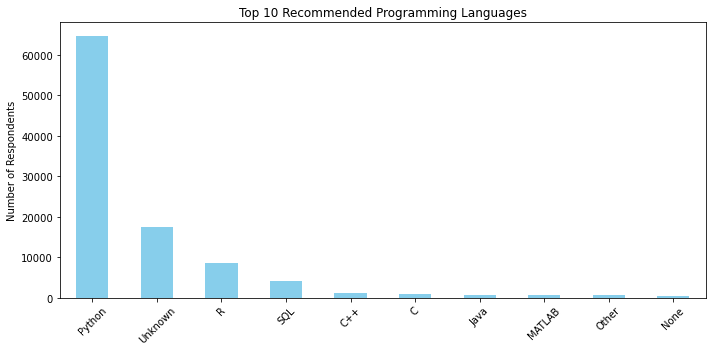

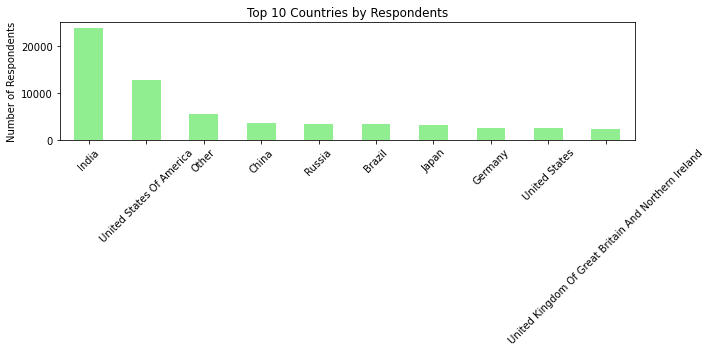

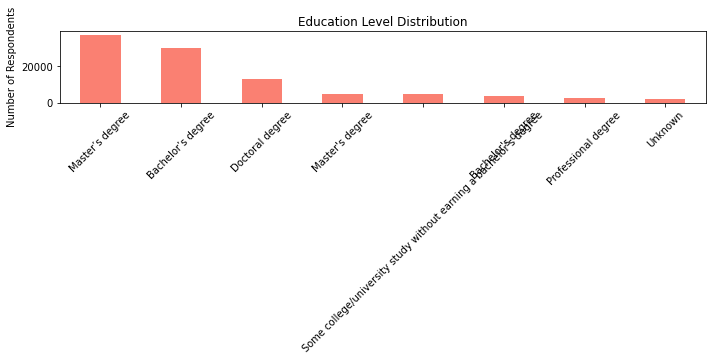

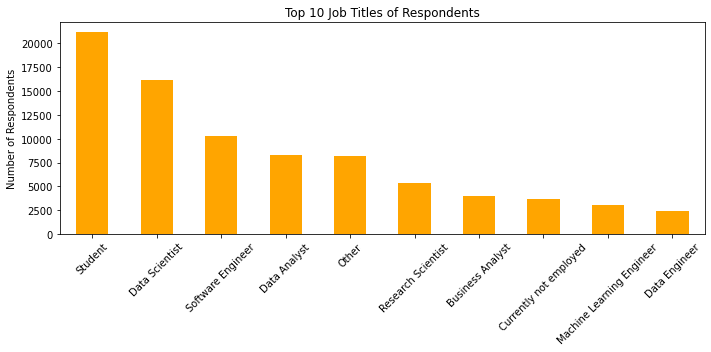

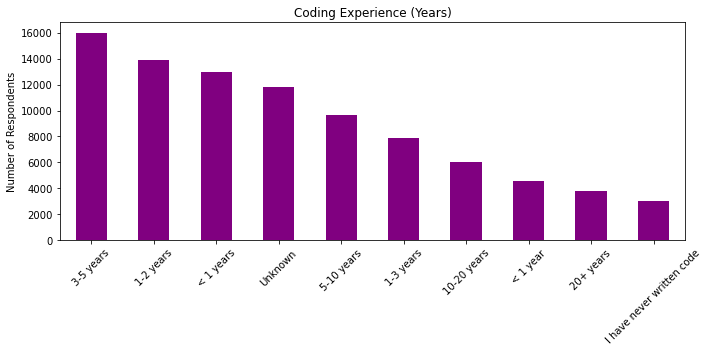

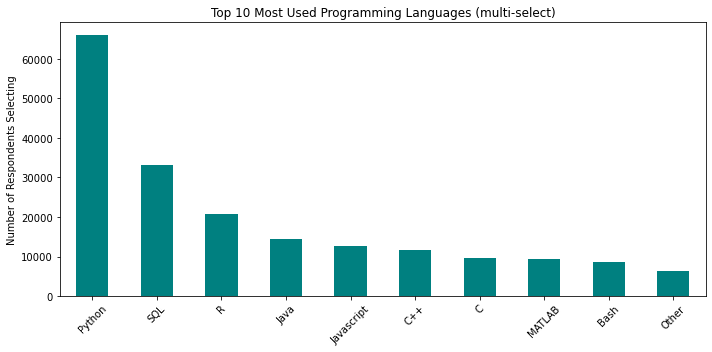

In [8]:
import matplotlib.pyplot as plt

# 1. Top 10 Recommended Languages (single-choice)
if col_reco_lang in work.columns:
    plt.figure(figsize=(10,5))
    work[col_reco_lang].value_counts().head(10).plot(kind='bar', color='skyblue')
    plt.title("Top 10 Recommended Programming Languages")
    plt.ylabel("Number of Respondents")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 2. Top 10 Countries
if col_country in work.columns:
    plt.figure(figsize=(10,5))
    work[col_country].value_counts().head(10).plot(kind='bar', color='lightgreen')
    plt.title("Top 10 Countries by Respondents")
    plt.ylabel("Number of Respondents")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3. Education Distribution
if col_edu in work.columns:
    plt.figure(figsize=(10,5))
    work[col_edu].value_counts().head(8).plot(kind='bar', color='salmon')
    plt.title("Education Level Distribution")
    plt.ylabel("Number of Respondents")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4. Top 10 Job Titles
if col_title in work.columns:
    plt.figure(figsize=(10,5))
    work[col_title].value_counts().head(10).plot(kind='bar', color='orange')
    plt.title("Top 10 Job Titles of Respondents")
    plt.ylabel("Number of Respondents")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 5. Coding Experience Distribution
if col_code_years in work.columns:
    plt.figure(figsize=(10,5))
    work[col_code_years].value_counts().head(10).plot(kind='bar', color='purple')
    plt.title("Coding Experience (Years)")
    plt.ylabel("Number of Respondents")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 6. Most Used Programming Languages (multi-select question)
if lang_usage_cols:
    lang_counts = pd.Series(
        { re.sub(r".* - ", "", c): work[c].notna().sum() for c in lang_usage_cols }
    ).sort_values(ascending=False)

    plt.figure(figsize=(10,5))
    lang_counts.head(10).plot(kind='bar', color='teal')
    plt.title("Top 10 Most Used Programming Languages (multi-select)")
    plt.ylabel("Number of Respondents Selecting")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
